In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scanpy as sc
sys.path.append("model")
sys.path.append("simulation")
from sc_topology_fast import analyze_array_topology_fast
from Bzinb_EM import BZINB_Model
from simulate import simulate_genes

In [2]:
adata = sc.read_h5ad("sim_data/adata.h5ad")

<Axes: >

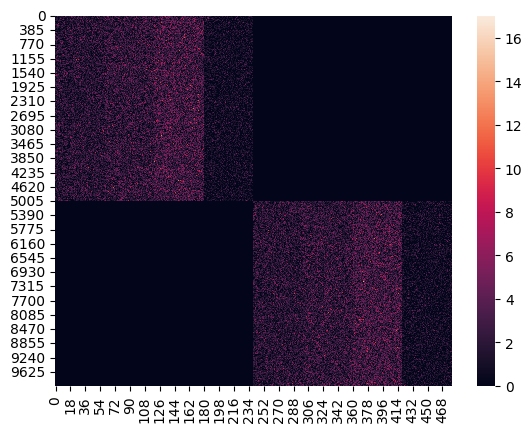

In [44]:
sns.heatmap(adata.X)

In [10]:
model = BZINB_Model()

In [26]:
params, pis = model.fit(adata.X[:,180], adata.X[:,181])

In [27]:
params

{'m1': np.float64(0.00013262055229644237),
 't1': np.float64(0.0001230301807033469),
 'm2': np.float64(0.00013634470214094269),
 't2': np.float64(0.00013241992486703516),
 'lam': np.float64(3.273241597285924)}

In [16]:
pis

array([0.49296004, 0.00680232, 0.00322586, 0.49701178])

In [18]:
params_, lambda_ = analyze_array_topology_fast(adata.X[:5000,0:240], pair_mode='adjacent_pairs')

In [19]:
import numpy as np
import pandas as pd
from typing import Dict, Any, Tuple


def _to_dense_gene_vector(X, j: int) -> np.ndarray:
    """从 adata.X 中取第 j 列并转成 1D dense int array"""
    col = X[:, j]
    # 兼容 scipy sparse
    if hasattr(col, "toarray"):
        col = col.toarray()
    col = np.asarray(col).reshape(-1)
    # 计数通常是非负整数
    return col.astype(int, copy=False)

def _merge_nb_params(
    nb_params: Dict[str, Dict[str, float]],
    gene_key: str,
    m: float,
    t: float,
    strategy: str = "keep_first"
):
    """
    将单次fit得到的(m,t)写入nb_params（转换成r=1/m, theta=t）
    strategy:
      - keep_first: 如果该gene已存在则不覆盖
      - overwrite: 直接覆盖
      - average_r_theta: 对r,theta做简单平均（不加权）
    """
    m = float(m)
    t = float(t)
    # 基本防护
    m = max(m, 1e-12)
    t = float(np.clip(t, 1e-12, 1 - 1e-12))
    r = 1.0 / m

    if gene_key not in nb_params:
        nb_params[gene_key] = {"r": r, "theta": t}
        return

    if strategy == "keep_first":
        return
    elif strategy == "overwrite":
        nb_params[gene_key] = {"r": r, "theta": t}
    elif strategy == "average_r_theta":
        nb_params[gene_key]["r"] = 0.5 * (nb_params[gene_key]["r"] + r)
        nb_params[gene_key]["theta"] = 0.5 * (nb_params[gene_key]["theta"] + t)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

def fit_pairs_bzinb_sequential(
    X,
    gene_indices: np.ndarray,
    model_factory,
    nb_strategy: str = "keep_first",
    store_pis: bool = False
) -> Tuple[Dict[str, Any], np.ndarray, np.ndarray, np.ndarray]:

    gene_indices = np.asarray(gene_indices)
    G = len(gene_indices)
    if G < 2:
        raise ValueError("gene_indices length must be >= 2")

    nb_params: Dict[str, Dict[str, float]] = {}
    lam_mat = np.full((G, G), np.nan, dtype=float)
    ok_mat = np.zeros((G, G), dtype=bool)

    pi_tensor = None
    if store_pis:
        pi_tensor = np.full((G, G, 4), np.nan, dtype=float)

    # 预取表达
    Y = [_to_dense_gene_vector(X, int(gi)) for gi in gene_indices]

    # 对角线
    for i in range(G):
        lam_mat[i, i] = 0.0
        ok_mat[i, i] = True
        if store_pis:
            pi_tensor[i, i, :] = np.array([np.nan, np.nan, np.nan, np.nan])

    # 只做 (0,1),(2,3)...
    for i in range(0, G - 1, 2):
        j = i + 1

        y1, y2 = Y[i], Y[j]
        g1_key = f"g{int(gene_indices[i])}"
        g2_key = f"g{int(gene_indices[j])}"

        model = model_factory()

        try:
            params, pis = model.fit(y1, y2)

            lam = float(params["lam"])
            lam_mat[i, j] = lam
            lam_mat[j, i] = lam
            ok_mat[i, j] = True
            ok_mat[j, i] = True

            if store_pis and pi_tensor is not None:
                pi_tensor[i, j, :] = np.asarray(pis, dtype=float)
                pi_tensor[j, i, :] = np.asarray(pis, dtype=float)

            _merge_nb_params(nb_params, g1_key, params["m1"], params["t1"], strategy=nb_strategy)
            _merge_nb_params(nb_params, g2_key, params["m2"], params["t2"], strategy=nb_strategy)

        except Exception:
            lam_mat[i, j] = np.nan
            lam_mat[j, i] = np.nan
            ok_mat[i, j] = False
            ok_mat[j, i] = False
            if store_pis and pi_tensor is not None:
                pi_tensor[i, j, :] = np.nan
                pi_tensor[j, i, :] = np.nan

    return nb_params, lam_mat, pi_tensor, ok_mat



In [20]:
# -------------------------
# 使用示例（你按需替换 gene_indices）
# -------------------------
gene_indices = np.array([i for i in range(240)])  # 举例：你要计算的基因列索引
nb_params, lam_mat, pi_tensor, ok_mat = fit_pairs_bzinb_sequential(
    X=adata.X,
    gene_indices=gene_indices,
    model_factory=lambda: BZINB_Model(),
    nb_strategy="keep_first",
    store_pis=False
)

print(nb_params)           # {'g62': {'r':..., 'theta':...}, ...}
print(lam_mat.shape)       # (G, G)
print(ok_mat.mean())       # 成功率

# 如果你想把 lambda 矩阵带上基因名做成 DataFrame：
gene_names = [f"g{int(i)}" for i in gene_indices]
lam_df = pd.DataFrame(lam_mat, index=gene_names, columns=gene_names)
# print(lam_df.iloc[:5, :5])

{'g0': {'r': 10.9073873328409, 'theta': 0.13940561737849805}, 'g1': {'r': 11.628627977304596, 'theta': 0.130825075198074}, 'g2': {'r': 9.277790209650961, 'theta': 0.1605839569727388}, 'g3': {'r': 11.819512686120781, 'theta': 0.13009875988285133}, 'g4': {'r': 9.050286636118946, 'theta': 0.16304492755567743}, 'g5': {'r': 12.637068639609854, 'theta': 0.11952301846211019}, 'g6': {'r': 12.69179046854007, 'theta': 0.12271521580889085}, 'g7': {'r': 13.095069285256411, 'theta': 0.11762417123366412}, 'g8': {'r': 8.545673148357167, 'theta': 0.17024835923191592}, 'g9': {'r': 9.02823104168414, 'theta': 0.16041983629576012}, 'g10': {'r': 9.571247886193323, 'theta': 0.15429118818681184}, 'g11': {'r': 7.1472437813979095, 'theta': 0.19641059194417215}, 'g12': {'r': 8.344666822829462, 'theta': 0.1749578463420321}, 'g13': {'r': 12.342898675526621, 'theta': 0.12648243487304484}, 'g14': {'r': 15.238776930746692, 'theta': 0.1060202406240192}, 'g15': {'r': 20.89922420087622, 'theta': 0.07819601142968904}, '

In [21]:
lam_df

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,g230,g231,g232,g233,g234,g235,g236,g237,g238,g239
g0,0.000000,1.948104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g1,1.948104,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g2,NaN,NaN,0.000000,2.109228,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g3,NaN,NaN,2.109228,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g4,NaN,NaN,NaN,NaN,0.0,2.377535,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.905327,0.0,NaN,NaN,NaN,NaN
g236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.756849,NaN,NaN
g237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.756849,0.000000,NaN,NaN
g238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.498228


In [22]:
r_dict = {g: d["r"] for g, d in nb_params.items()}
theta_dict = {g: d["theta"] for g, d in nb_params.items()}

r_dict_gd = {g: d["r"] for g, d in params_.items()}
theta_dict_gd = {g: d["theta"] for g, d in params_.items()}

In [23]:
r_esti = list(r_dict.values())
theta_esti = list(theta_dict.values())

r_gd = list(r_dict_gd.values())
theta_gd = list(theta_dict_gd.values())

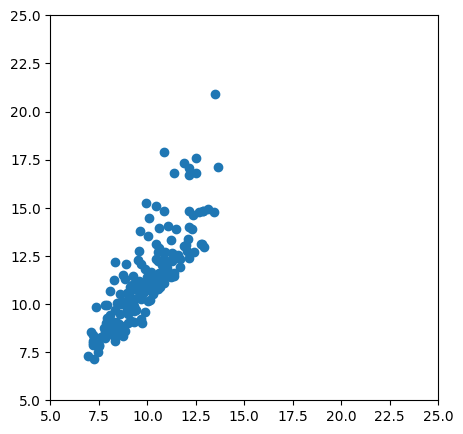

In [28]:
plt.figure(figsize=(5, 5))

plt.scatter(r_gd[0:180],r_esti[0:180])
plt.xlim(5,25)
plt.ylim(5,25)
plt.show()

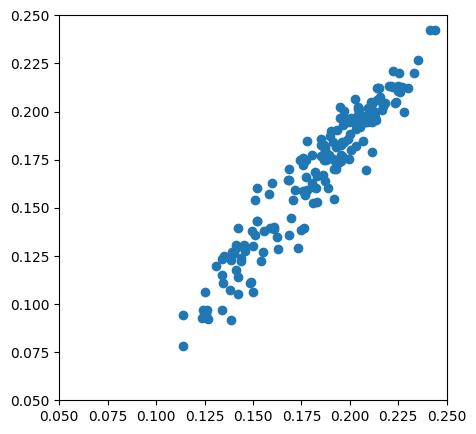

In [30]:
plt.figure(figsize=(5, 5))

plt.scatter(theta_gd[0:180],theta_esti[0:180])
plt.xlim(0.05,0.25)
plt.ylim(0.05,0.25)
plt.show()

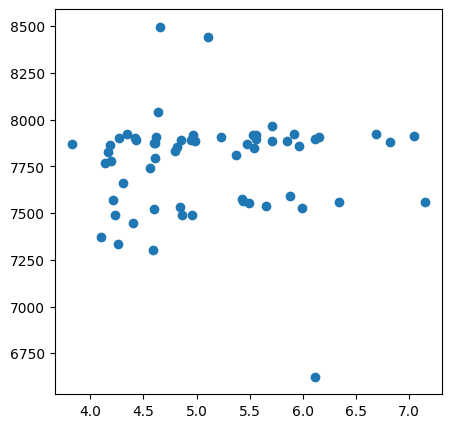

In [33]:
plt.figure(figsize=(5, 5))

plt.scatter(r_gd[180:],r_esti[180:])
# plt.xlim(5,25)
# plt.ylim(5,25)
plt.show()

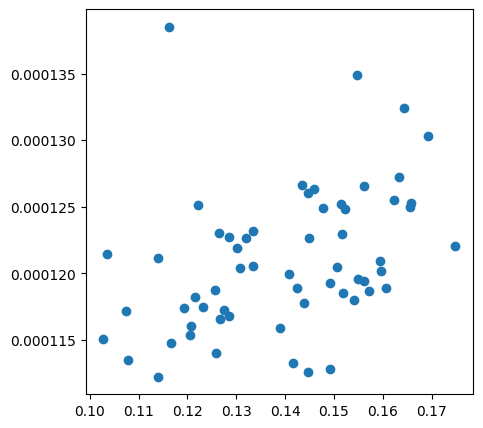

In [32]:
plt.figure(figsize=(5, 5))

plt.scatter(theta_gd[180:],theta_esti[180:])
# plt.xlim(0.05,0.25)
# plt.ylim(0.05,0.25)
plt.show()

In [34]:
lambda_

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,g230,g231,g232,g233,g234,g235,g236,g237,g238,g239
g0,0.000000,1.793565,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g1,1.793565,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g2,0.000000,0.000000,0.000000,1.975807,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g3,0.000000,0.000000,1.975807,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g4,0.000000,0.000000,0.000000,0.000000,0.0,1.986968,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g235,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.029926,0.0,0.000000,0.000000,0.000000,0.000000
g236,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.078765,0.000000,0.000000
g237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,-0.078765,0.000000,0.000000,0.000000
g238,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.030577


In [36]:
lam_mat = np.nan_to_num(lam_mat, nan=0.0)

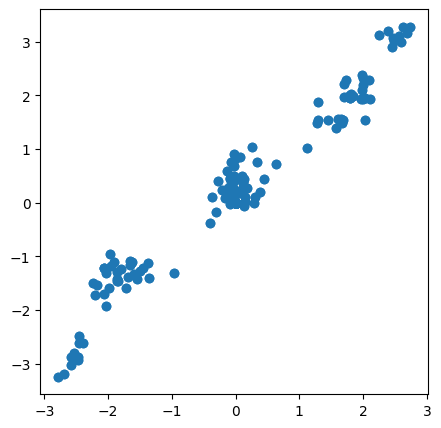

In [43]:
plt.figure(figsize=(5, 5))

plt.scatter(lambda_.values.flatten(),lam_mat.flatten())
# plt.xlim(0.05,0.25)
# plt.ylim(0.05,0.25)
plt.show()